Shows how one can generate text given a prompt and some hyperparameters, using either minGPT or huggingface/transformers

In [1]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from mingpt.model import GPT
from mingpt.utils import set_seed
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
set_seed(3407)

In [2]:
# Load the dataset
dataset = load_dataset("togethercomputer/RedPajama-Data-1T-Sample", 'plain_text', cache_dir='datasets')
dataset = dataset['train']

Found cached dataset red_pajama-data-1_t-sample (/Users/dylanskinner/Desktop/CS 674 Projects/MinGPT_UL2/datasets/togethercomputer___red_pajama-data-1_t-sample/plain_text/1.0.0/6ea3bc8ec2e84ec6d2df1930942e9028ace8c5b9d9143823cf911c50bbd92039)


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
# Custom dataset class for the Red Pajama dataset
class RedPajamaDataset(Dataset):
    def __init__(self, data, max_length=1024):
        self.data = data
        self.tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        self.tokenizer.pad_token_id = 50256
        self.max_length = max_length
        self.vocab_size = self.tokenizer.vocab_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]['text']
        # Tokenize the text
        tokens = self.tokenizer.encode(text, add_special_tokens=True, max_length=self.max_length, truncation=True, return_tensors='pt', padding=True)
        # Split the tokens into chunks of max_length
        # Shift the tokens to get targets (excluding the [CLS] token)
        target_tokens = tokens[:, 1:].clone()  # Exclude the [CLS] token
        tokens = tokens[:, :-1]  # Exclude the last token to match the shifted targets
        return tokens, target_tokens
    

# Create an instance of the custom dataset
red_pajama_dataset = RedPajamaDataset(dataset)
# print(red_pajama_dataset[0].device)

In [8]:
# create a GPT instance
from mingpt.model import GPT
import os

checkpoint_dir = 'red_pajama'
dir_path = f'./checkpoints/{checkpoint_dir}'

if not os.path.exists(dir_path):
    # If the directory doesn't exist, create it
    os.makedirs(dir_path)
    checkpoints = os.listdir(dir_path)
else:
    checkpoints = os.listdir(dir_path)

checkpoints.sort()



model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = red_pajama_dataset.vocab_size
model_config.block_size = red_pajama_dataset.max_length
model_config.checkpoint = f'checkpoints/{checkpoint_dir}/' + checkpoints[-1] if checkpoints else None
model = GPT(model_config)

number of parameters: 2.55M


In [9]:
# create a Trainer object
from mingpt.trainer import Trainer
iters = 500

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.max_iters = iters + model.iter_num if model_config.checkpoint else iters  # This is a change
train_config.num_workers = 0
train_config.checkpoint_iters = 100     # This is a change
train_config.batch_size = 1
train_config.checkpoint_name = f'{checkpoint_dir}/checkpoint'  # This is a change.
trainer = Trainer(train_config, model, red_pajama_dataset)

running on device cpu


iter_dt 0.00ms; iter 0: train loss 10.83966
iter_dt 56.91ms; iter 100: train loss 8.90698
iter_dt 53.88ms; iter 200: train loss 7.68957
iter_dt 220.33ms; iter 300: train loss 7.57169
iter_dt 45.08ms; iter 400: train loss 9.09287


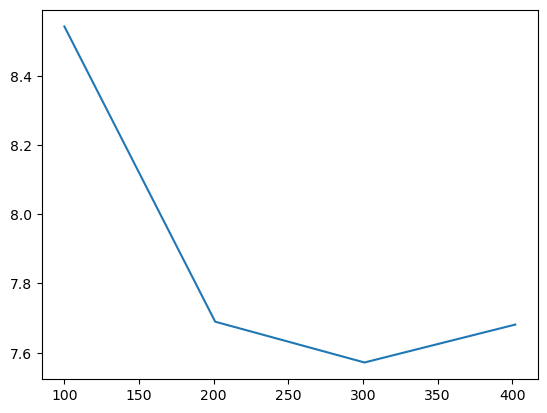

In [10]:
def batch_end_callback(trainer):
    if trainer.iter_num % 100 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
trainer.set_callback('on_batch_end', batch_end_callback)

trainer.run()

# Plot the loss
plt.plot(trainer.iter_list, [a.detach() for a in trainer.saved_loss])
plt.show()

In [ ]:

def generate(prompt='', num_samples=10, steps=20, do_sample=True):
        
    # tokenize the input prompt into integer input sequence
    tokenizer = GPT2Tokenizer.from_pretrained(model_type)
    if prompt == '': 
        # to create unconditional samples...
        # huggingface/transformers tokenizer special cases these strings
        prompt = '<|endoftext|>'
    encoded_input = tokenizer(prompt, return_tensors='pt').to(device)
    x = encoded_input['input_ids']
    
    # we'll process all desired num_samples in a batch, so expand out the batch dim
    x = x.expand(num_samples, -1)

    # forward the model `steps` times to get samples, in a batch
    y = model.generate(x, max_new_tokens=steps, do_sample=do_sample, top_k=40)
    
    for i in range(num_samples):
        out = tokenizer.decode(y[i].cpu().squeeze())
        print('-'*80)
        print(out)
        

In [ ]:
generate(prompt='Dylan Skinner is the', num_samples=10, steps=20)

--------------------------------------------------------------------------------
Dylan Skinner is the author of "The Biggest Bad Boy in America": A History of Black America at the University of
--------------------------------------------------------------------------------
Dylan Skinner is the President of Kratom Awareness Month, a national coalition of community health advocates and activists who call for more
--------------------------------------------------------------------------------
Dylan Skinner is the author of "Dylan's War: What I Learned as a Boy a Slave" and other books
--------------------------------------------------------------------------------
Dylan Skinner is the co-founder of the Internet Archive, and currently serves as a director at Creative Cloud Group.<|endoftext|>
--------------------------------------------------------------------------------
Dylan Skinner is the CEO of V.U.

He recently shared a series of questions in which he spoke with
-------------------